# Analysing the solution space

The creation of an algorithm that generates all feasible solutions with equal probability enabled us to explore and analyse the distribution of costs. We created this to analyse a given dataset.

In [2]:
from paintshop import PaintShop, Source
from solution_space import get_solution_space_size

# Load dataset
# PS = PaintShop(Source.SEPTEMBER)
PS = PaintShop(Source.NOVEMBER)

Loaded 'resources\PaintShop - November 2024.xlsx'


We first import the datasets and calculate the size of the respective solution spaces

In [3]:
print(f'{PS.source_id}:')
print(f"|O|: {PS.order_count}")
print(f"|M|: {PS.machine_count}")
print(f"|S|: {get_solution_space_size(PS):.0e} ({get_solution_space_size(PS)})")

NOVEMBER:
|O|: 46
|M|: 4
|S|: 5e+27 (4951760157141521099596496896)


Lets test if we can generate a random solution. Go ahead, run it a few times.

In [4]:
from heuristics_constructive import Random

generator = Random(PS)

In [5]:
print(generator.generate())

    |  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  | 9565.53 ✔
M1: |  0   2   4   6   7  13  14  18  20  24  27  28  30  35  40  | 6108.00 (64%)
M2: |  3  10  17  19  22  23  26  31  34  36  38  39  41          | 2026.00 (21%)
M3: |  1   5   8   9  21  32  33  42  44                          | 792.47  (8%)
M4: | 11  12  15  16  25  29  37  43  45                          | 639.06  (7%)


Now lets generate a sample of costs from the solution space.

In [6]:
import os
import pickle
from time import time

target_sample_size = 1000000
sample_batch_size  = 1000

# Ensure chache folder exists
cache_folder = os.path.join('cache', 'solution_space_cost_samples')
if not os.path.exists(cache_folder):
    os.mkdir(cache_folder)
    
# Set cache file path
cache_file_path = os.path.join(cache_folder, f'{PS.source_id}.pickle')

# Load existing sample if exists
samples = []
if os.path.exists(cache_file_path):
    with open(cache_file_path,'rb') as file:
        cached_samples = pickle.load(file)
    print(f"Loaded {len(cached_samples)} samples from '{cache_file_path}'.")
    samples += cached_samples

# Create the rest of the samples if needed
missing_sample_count = target_sample_size - len(samples)
if missing_sample_count > 0:
    
    # Generate missing samples
    while len(samples) < target_sample_size:
        
        samples_to_generate = min(sample_batch_size, missing_sample_count)
        
        t0 = time()
        samples += [generator.generate().cost for _ in range(samples_to_generate)]
        print(f"{len(samples)} | {time() - t0:.2f}s")
    
    # Save samples
    with open(cache_file_path, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(samples, outp, pickle.HIGHEST_PROTOCOL)
    print(f"Saved: '{cache_file_path}'")

Loaded 1000000 samples from 'cache\solution_space_cost_samples\NOVEMBER.pickle'.


First, we'll plot the distribution of costs.

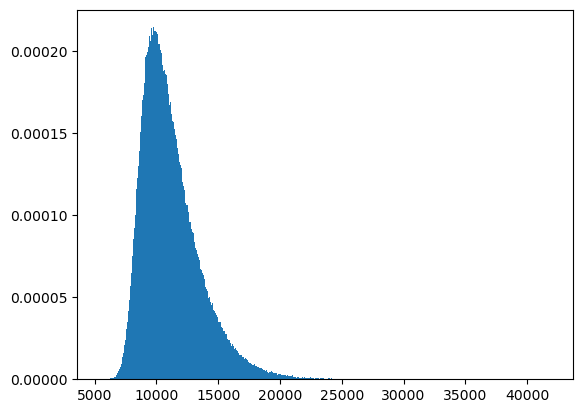

In [7]:
import matplotlib.pyplot as plt
plt.hist(samples, bins = 1000, density = True)
plt.show()

### Interestingly, settings the x-axis to log makes it look more like a normal-distribution

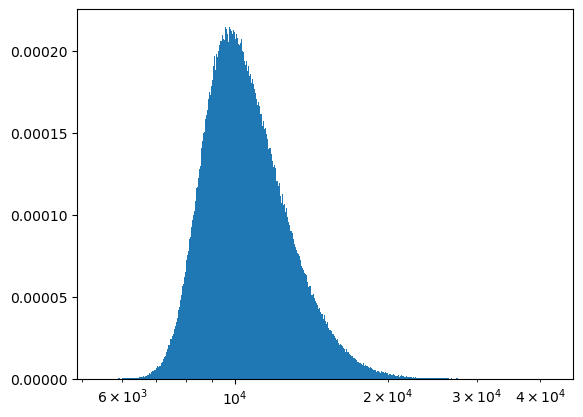

In [8]:
from functools import partial
from math import e, exp, log
import matplotlib.pyplot as plt
import numpy as np

plt.xscale('log')
plt.hist(samples, bins = 1000, density = True)
plt.show()

### Lets try a whole set of fits to see which one works the best. This can take a few minutes.

In [9]:
from distfit import distfit

# Initialize distfit
dist = distfit(n_boots=10)

# Determine best-fitting probability distribution for data
dist.fit_transform(np.array(samples))

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.14 sec] [RSS: 2.33225e-07] [loc=11192.678 scale=2409.045]
[distfit] >INFO> [expon     ] [0.14 sec] [RSS: 1.53237e-06] [loc=5419.765 scale=5772.914]
[distfit] >INFO> [pareto    ] [1.30 sec] [RSS: 1.53237e-06] [loc=-274877901524.235 scale=274877906944.000]
[distfit] >INFO> [dweibull  ] [9.81 sec] [RSS: 1.6384e-07] [loc=10873.636 scale=1897.273]
[distfit] >INFO> [t         ] [58.3 sec] [RSS: 2.33224e-07] [loc=11192.677 scale=2409.043]
[distfit] >INFO> [genextreme] [65.6 sec] [RSS: 1.73923e-06] [loc=-277.622 scale=6166.684]
[distfit] >INFO> [gamma     ] [13.5 sec] [RSS: 1.49075e-07] [loc=-5747.222 scale=303.232]
[distfit] >INFO> [lognorm   ] [1.72 sec] [RSS: 5.04478e-09] [loc=5395.345 scale=5357.621]
[distfit] >INFO> [beta      ] [21.5 sec] [RSS: 7.73995e-08] [loc=5419.666 scale=36604.245]
[distfit] >INFO> [uniform   ] [0.12 sec] [RSS: 1.9309e-06] [loc=5419.765 scale=36501.294]
[distfit] >INFO> [loggamma  ] [1

{'model': {'name': 'lognorm',
  'score': 5.044779114824972e-09,
  'loc': 5395.3454340033,
  'scale': 5357.6214718549345,
  'arg': (0.3959401114831834,),
  'params': (0.3959401114831834, 5395.3454340033, 5357.6214718549345),
  'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1a8444dd1d0>,
  'bootstrap_score': 0.0,
  'bootstrap_pass': False,
  'color': '#e41a1c',
  'CII_min_alpha': 8188.737336018407,
  'CII_max_alpha': 15671.063572576824},
 'summary':           name     score                  loc                scale  \
 0      lognorm       0.0          5395.345434          5357.621472   
 1         beta       0.0          5419.666156         36604.244914   
 2        gamma       0.0         -5747.222231           303.231749   
 3     dweibull       0.0         10873.636023          1897.272929   
 4            t       0.0         11192.676736          2409.042563   
 5         norm       0.0         11192.678376          2409.045334   
 6     loggamma       0.0    

[distfit] >INFO> Ploting Summary.
[distfit] >INFO> Bootstrap results are included..


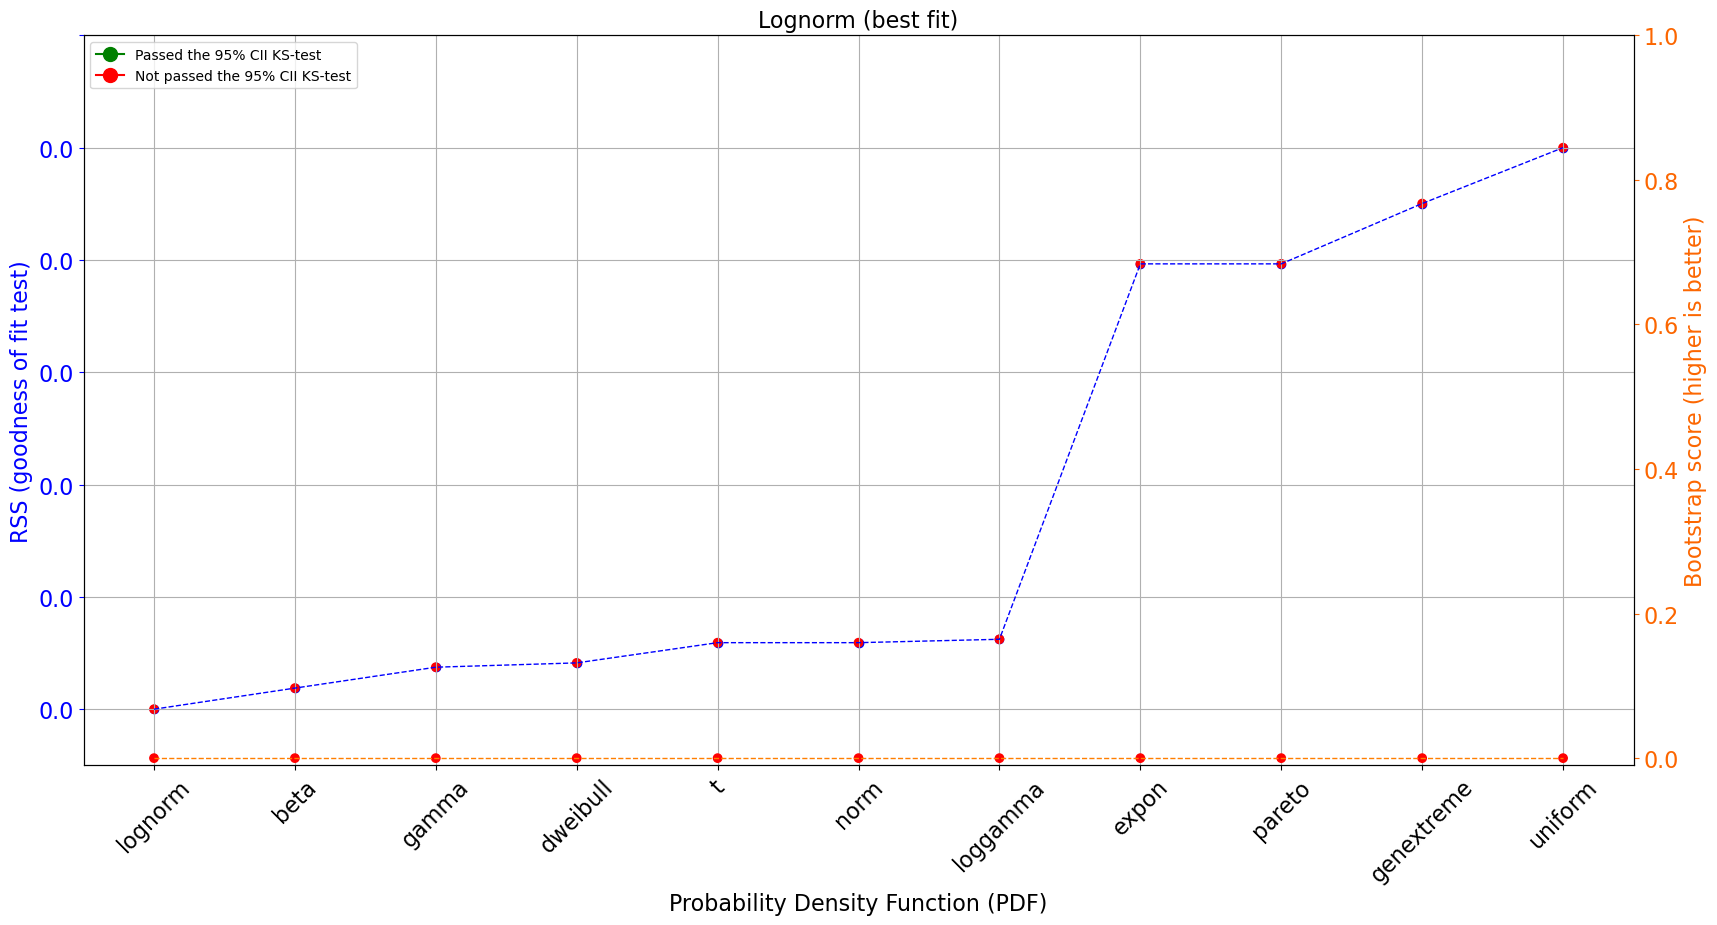

In [10]:
dist.plot_summary()
plt.show()

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Lognorm(loc:5395.345434, scale:5357.621472)


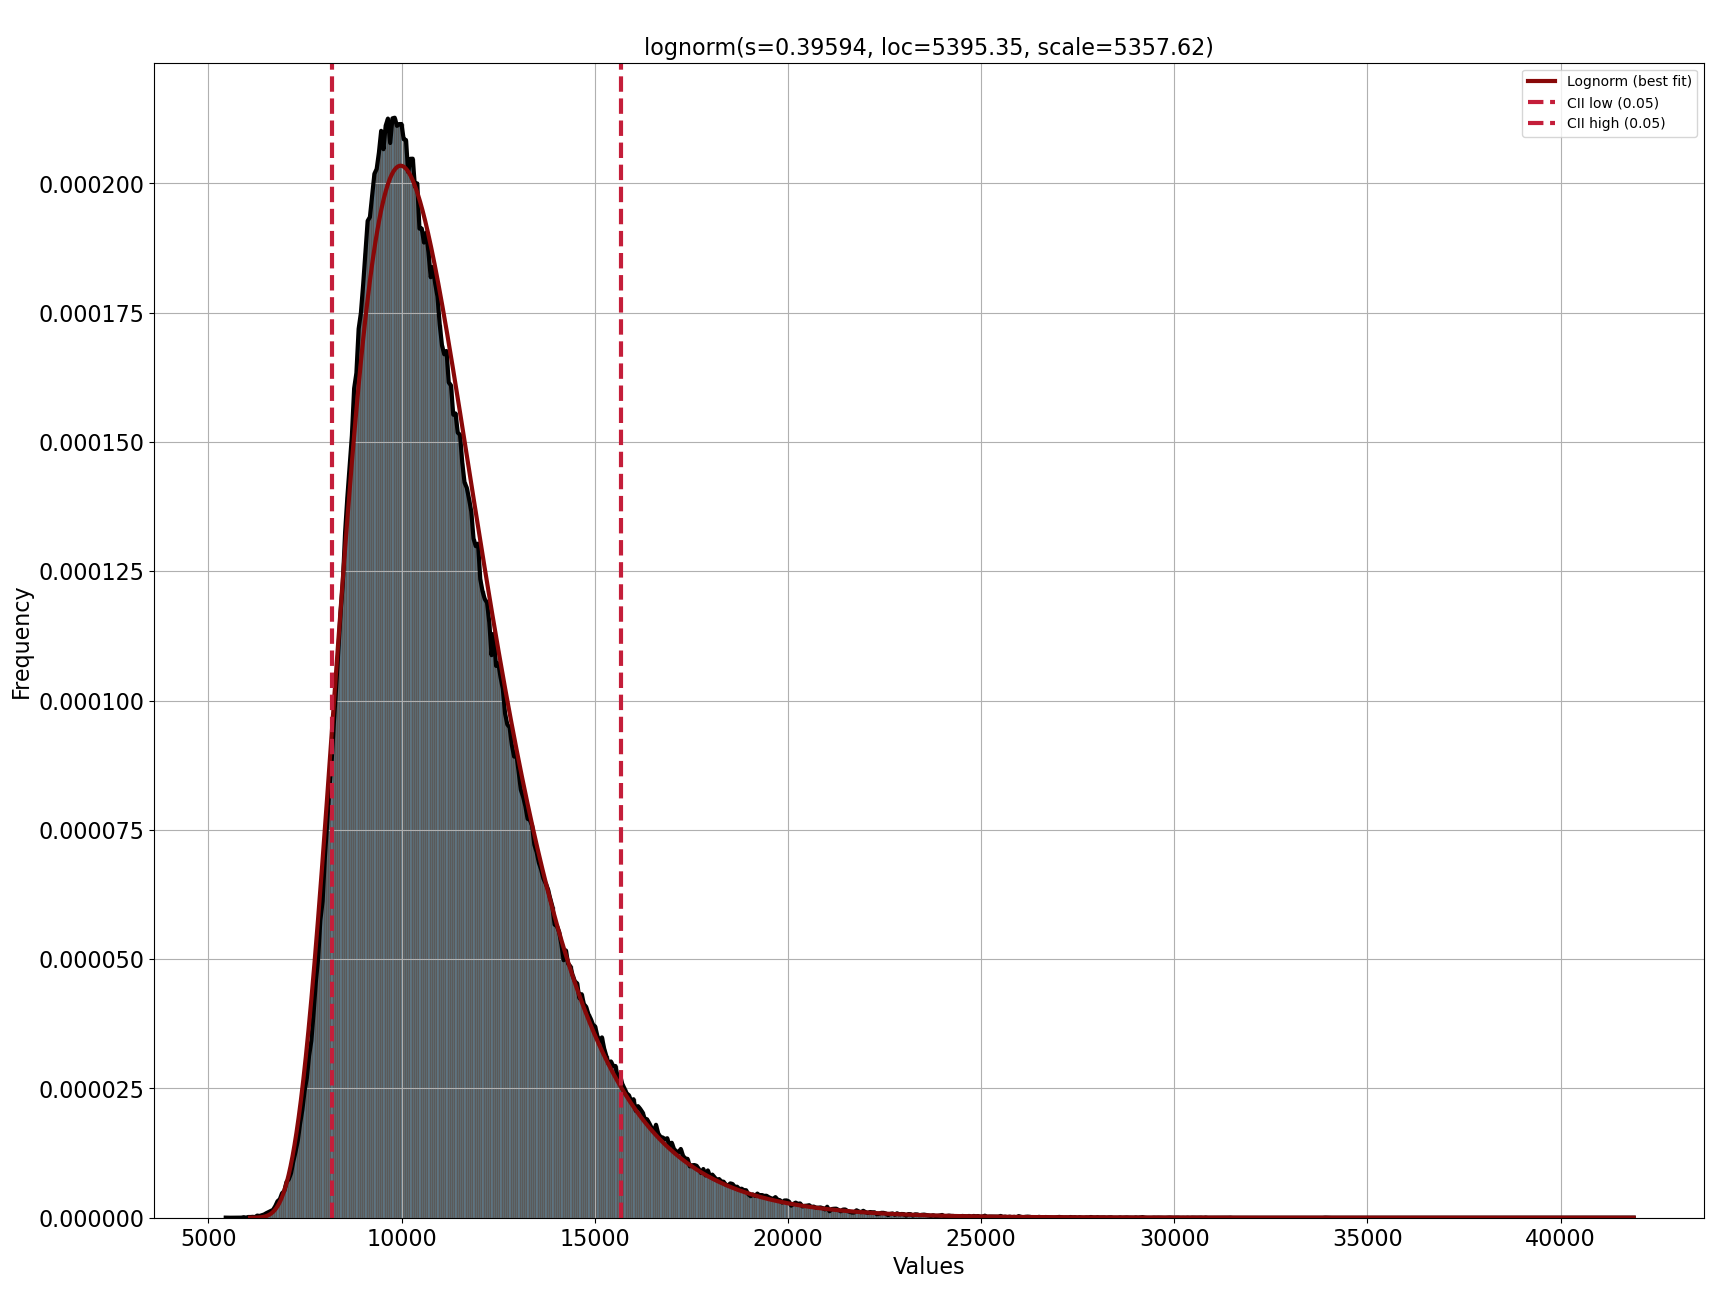

In [11]:
dist.plot()
plt.show()

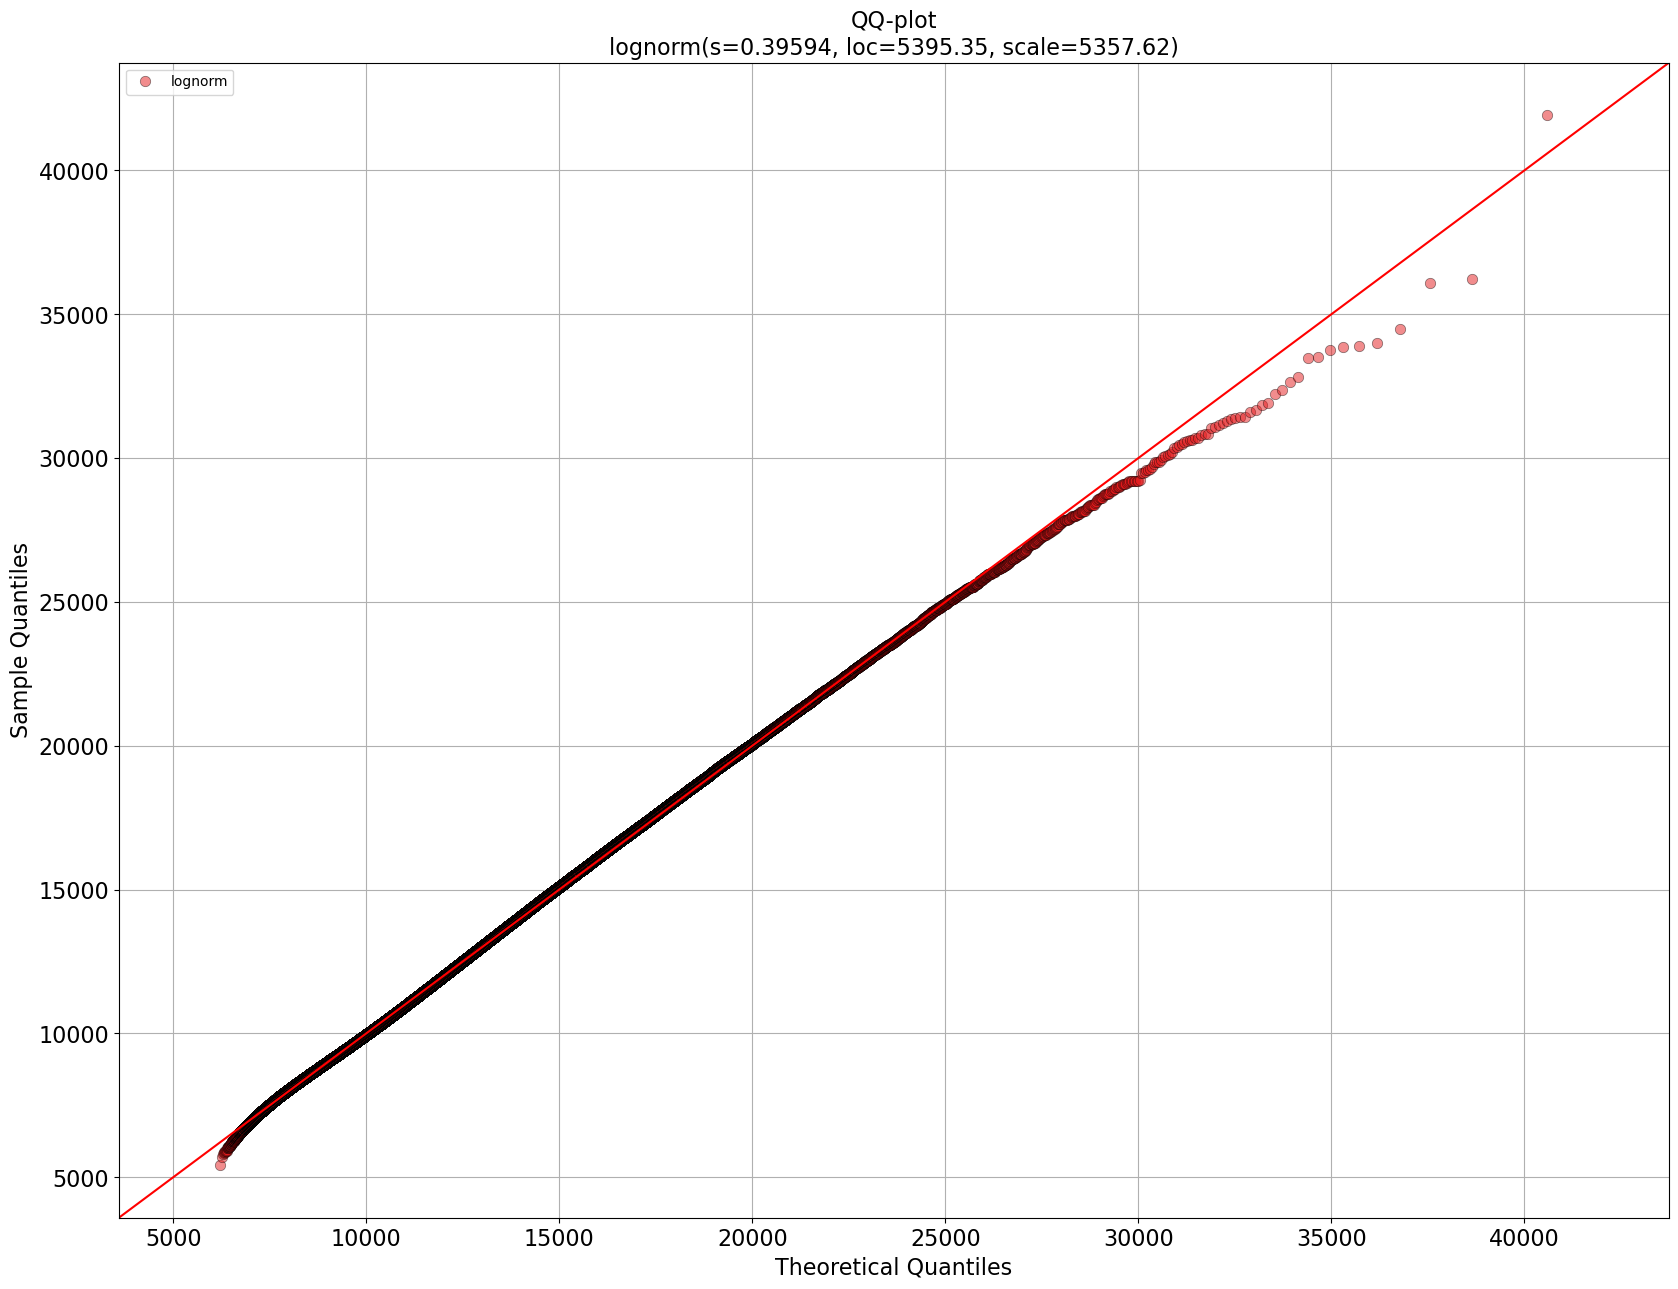

In [12]:
dist.qqplot(np.array(samples))
plt.show()

### Now lets use that to create a scipy.stats model

In [13]:
params = dist.model["params"]
params

(0.3959401114831834, 5395.3454340033, 5357.6214718549345)

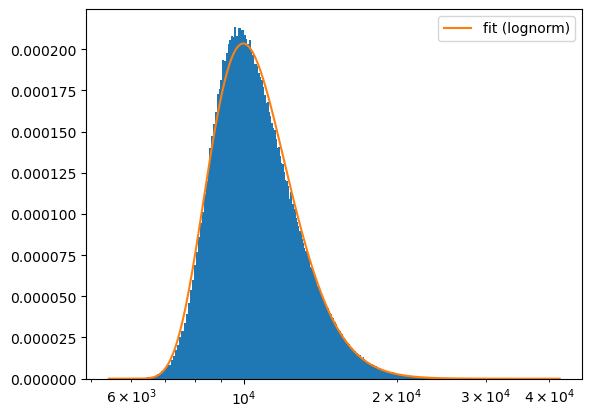

In [14]:
# model = stats.genextreme
from scipy import stats

xs = np.linspace(min(samples), max(samples), 1000)
model = stats.lognorm

plt.hist(samples, bins = 500, density = True)
plt.plot(xs, model.pdf(xs, *params), label = f'fit ({model.name})')
plt.legend()
plt.xscale('log')
plt.show()

### With it, we can make estimates about the number of solutions with a cost below a certain value.

In [15]:
# Chance of getting the best solutions:
cost = 5500
print("Cost    |   p          |   Est. #")
print("-----------------------------------")
while model.cdf(cost, *params) > 0:
    print(f"<{cost}   |   {model.cdf(cost, *params):.2e}   |   {model.cdf(cost, *params) * get_solution_space_size(PS):.2e}")
    cost -= 10

Cost    |   p          |   Est. #
-----------------------------------
<5500   |   1.40e-23   |   6.91e+04
<5490   |   1.06e-24   |   5.25e+03
<5480   |   5.59e-26   |   2.77e+02
<5470   |   1.86e-27   |   9.19e+00
<5460   |   3.34e-29   |   1.65e-01
<5450   |   2.58e-31   |   1.28e-03
<5440   |   5.89e-34   |   2.92e-06
<5430   |   1.98e-37   |   9.80e-10
<5420   |   2.26e-42   |   1.12e-14
<5410   |   1.53e-50   |   7.56e-23
<5400   |   3.42e-71   |   1.70e-43


### We estimate the number of perfect solutions to be:

In [16]:
# Number of estimated solutions with 0 cost:
get_solution_space_size(PS) * model.cdf(0, *params)

0.0

### We can also predict the cost of the worst of the top X solutions.

In [49]:
# Number of estimated solutions
from math import isnan


print(f"{'Cost':<5}  |  p(x < X)  |  {'Est. #'}")
print("-------------------------------")
for num_equal_or_better in np.logspace(0, 30, 31):
    chance = num_equal_or_better / get_solution_space_size(PS)
    cost = model.ppf(chance, *params)
    
    if isnan(cost):
        break
    
    print(f"{cost:<5.0f}  |  {model.cdf(cost, *params):.2e}  |  {num_equal_or_better:.0f}")

Cost   |  p(x < X)  |  Est. #
-------------------------------
5464   |  2.02e-28  |  1
5470   |  2.02e-27  |  10
5477   |  2.02e-26  |  100
5484   |  2.02e-25  |  1000
5492   |  2.02e-24  |  10000
5502   |  2.02e-23  |  100000
5512   |  2.02e-22  |  1000000
5523   |  2.02e-21  |  10000000
5536   |  2.02e-20  |  100000000
5551   |  2.02e-19  |  1000000000
5568   |  2.02e-18  |  10000000000
5587   |  2.02e-17  |  100000000000
5609   |  2.02e-16  |  1000000000000
5634   |  2.02e-15  |  10000000000000
5664   |  2.02e-14  |  100000000000000
5698   |  2.02e-13  |  1000000000000000
5739   |  2.02e-12  |  10000000000000000
5788   |  2.02e-11  |  100000000000000000
5846   |  2.02e-10  |  1000000000000000000
5917   |  2.02e-09  |  10000000000000000000
6005   |  2.02e-08  |  100000000000000000000
6116   |  2.02e-07  |  1000000000000000000000
6259   |  2.02e-06  |  10000000000000000000000
6450   |  2.02e-05  |  100000000000000008388608
6716   |  2.02e-04  |  999999999999999983222784
7112   |  2.02